### EXP: Pilote1 QC rating 

- **Aim:** Test reliability of quality control (QC) of brain registration ratings between two experts raters (PB: Pierre Bellec, YB: Yassine Benahajali) based on internaly drafted qc protocol( ref: https://figshare.com/articles/Quality_Control_and_assessment_of_the_NIAK_functional_MRI_preprocessing_pipeline/4204845/1 ).

- **Exp:** 
    - 220 anatomical brain images from ADHD200 dataset preprocced with two differents pipelines (NIAK and Athena).
    - Each rater (PB and YB) rated (OK, Maybe or Fail) both NIAK and Athena images using volume based visualization tool (register) from minctools.

In [654]:
import os
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt

In [655]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [656]:
# Read raw table
ratings = pd.read_csv('../data/rating/Pilot_QC_Pierre_Yassine-12-10-2018.csv')
ratings.head()

,id_subject,status_Athena,status_NIAK,status_Athena.1,status_NIAK.1
0,X0026001,Maybe,Maybe,Maybe,Maybe
1,X0026002,Maybe,Maybe,Maybe,Maybe
2,X0026004,Maybe,Maybe,Maybe,Maybe
3,X0026005,Maybe,Maybe,Maybe,Maybe
4,X0026009,Maybe,Maybe,Maybe,Maybe


In [657]:
# Rename columns
ratings.rename(index=str, columns={"status_Athena": "PB_Athena", "status_NIAK": "PB_NIAK",
                                   "status_Athena.1": "YB_Athena", "status_NIAK.1": "YB_NIAK"},inplace=True)
ratings.describe()

,id_subject,PB_Athena,PB_NIAK,YB_Athena,YB_NIAK
count,220,220,220,220,220
unique,220,4,4,3,3
top,X0020015,Maybe,OK,Maybe,OK
freq,1,109,147,110,146


In [658]:
# Strip wite sapces 
ratings['PB_Athena'] = ratings['PB_Athena'].str.strip()
ratings['PB_NIAK'] = ratings['PB_NIAK'].str.strip()
ratings.describe()

,id_subject,PB_Athena,PB_NIAK,YB_Athena,YB_NIAK
count,220,220,220,220,220
unique,220,3,3,3,3
top,X0020015,Maybe,OK,Maybe,OK
freq,1,109,147,110,146


In [659]:
# Add matching column between the raters for each of the preprocessing pipeline
ratings.loc[:,"rating_match_NIAK"] = ratings.loc[:,['PB_NIAK','YB_NIAK']].apply(lambda x: len(set(x)) == 1, axis=1)
ratings.loc[:,"rating_match_Athena"] = ratings.loc[:,['PB_Athena','YB_Athena']].apply(lambda x: len(set(x)) == 1, axis=1)

In [7]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
ratings.tail()

,id_subject,PB_Athena,PB_NIAK,YB_Athena,YB_NIAK,rating_match_NIAK,rating_match_Athena
215,X0010100,1,1,1,1,True,True
216,X0010101,2,1,1,1,True,False
217,X0010102,2,1,2,1,True,True
218,X0010103,2,1,2,1,True,True
219,X0010104,1,1,1,1,True,True


In [482]:
# calculate the percentage of agreement  between raters for each pipeline
agreem_ = (ratings.rating_match_Athena.sum()/ratings.id_subject.count())*100
print("The percentage of agreement for Athena preprocessed images is: {:.2f}".format(agreem_))
agreem_ = (ratings.rating_match_NIAK.sum()/ratings.id_subject.count())*100
print("The percentage of agreement for NIAK preprocessed images is: {:.2f}".format(agreem_))

The percentage of agreement for Athena preprocessed images is: 76.82
The percentage of agreement for NIAK preprocessed images is: 85.45


In [666]:
# Percenteage of agrrement between raters
agree_niak = ratings[['PB_NIAK','YB_NIAK']]
agree_athena = ratings[['PB_Athena','YB_Athena']]
%Rpush agree_niak agree_athena
agree_n = %R agree(agree_niak)
agree_a = %R agree(agree_athena)
print('NIAK'),print(agree_n)
print('Athena'),print(agree_a)

NIAK
 Percentage agreement (Tolerance=0)

 Subjects = 220 
   Raters = 2 
  %-agree = 85.5 

Athena
 Percentage agreement (Tolerance=0)

 Subjects = 220 
   Raters = 2 
  %-agree = 76.8 



(None, None)

In [667]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [668]:
def kappa_score(k_df):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            %Rpush user1_id user1 user2_id user2
            kappaR =  %R kappa2(k_df[,c(user1,user2)],c(0,1,2))
            #kappa = metrics.cohen_kappa_score(list(k_df[user1]),list(k_df[user2]))
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
    return k_store, p_store

In [669]:
# Get Kappa score out of all different combination of ratings
kappa_df  = ratings[['PB_Athena','YB_Athena','PB_NIAK','YB_NIAK']]
kappa_store, Pval_store = kappa_score(kappa_df)
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(kappa_store.mean(), kappa_store.std()))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df)
print(fleiss_kappa)

Mean Kappa : 0.58 , std : 0.28

 Fleiss' Kappa for m Raters

 Subjects = 220 
   Raters = 4 
    Kappa = 0.412 

        z = 17.1 
  p-value = 0 



In [670]:
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = True):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

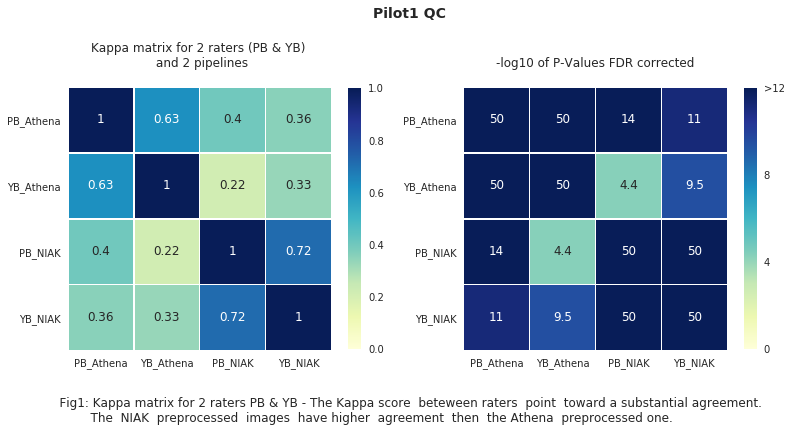

In [689]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())
Pval_out = pd.DataFrame(fdr_transf(Pval_store), 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())



# Set up the matplotlib figure
f, axes = plt.subplots(1, 2,figsize = (13,8))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot1 QC',x=0.49,y=.87, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,annot=True,
            linewidths=.5, cbar_kws={"shrink": .6}, ax=axes[0])
axes[0].set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes[0].set_yticklabels(kappa_df.columns,rotation=0)
axes[0].set_title('Kappa matrix for 2 raters (PB & YB) \n and 2 pipelines',pad=20,fontsize=12)

# Draw P-value heat map
ax = sns.heatmap(Pval_out,cmap="YlGnBu",
            square=True,annot=True,
            linewidths=.5, cbar_kws={"shrink": .6}, ax=axes[1],vmin=0,vmax=12)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 4, 8, 12])
cbar.set_ticklabels(['0', '4', '8', '>12'])

axes[1].set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes[1].set_yticklabels(kappa_df.columns,rotation=0)
axes[1].set_title('-log10 of P-Values FDR corrected',pad=20,fontsize=12)

# Caption
txt = '''
    Fig1: Kappa matrix for 2 raters PB & YB - The Kappa score  beteween raters  point  toward a substantial agreement. 
            The  NIAK  preprocessed  images  have higher  agreement  then  the Athena  preprocessed one. '''
f.text(.1,0.15,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/pilot_qc.svg')


In [495]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)